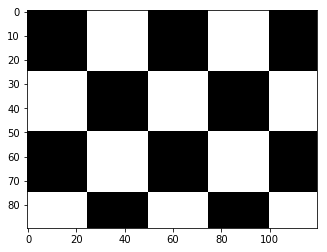

Time (ARM): 13.622583150863647 sec


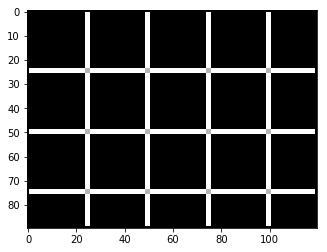

Load overlay
Open Xlnk
Allocating CMA for input
Allocating CMA for output
Transfering input buffer
Transfering output buffer
Waiting for input buffer...
Transfer input buffer done!
Waiting for output buffer...
Transfer output buffer done!
Time (FPGA): 0.01150202751159668 sec


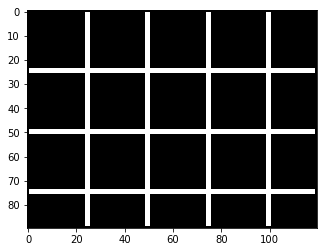

In [6]:
import subprocess
import sys
import cv2
import numpy as np
import time
import math
from matplotlib import pyplot as plt

from pynq import Overlay
import pynq.lib.dma
from pynq import Xlnk
from pynq.lib.video import *
from pynq import MMIO

USE_SW = 1
USE_HW = 1

USE_IMG_SQUARE = 0 # 120x90 pixels
USE_IMG_RECTS = 0 # 120x90 pixels
USE_IMG_CHECKERBOARD = 1 # 120x90 pixels
USE_IMG_LENNA = 0 # 512x512 pixels
USE_IMG_SCHLOSS = 0  # 1920x1080 pixels
USE_IMG_NYC = 0 # 3840x2160 pixels

if USE_IMG_SQUARE:
    imgInName = "images/square.png"
    FRAME_IN_W = 120
    FRAME_IN_H = 90
if USE_IMG_RECTS:
    import os
    imgInName = "images/rects.png"
    FRAME_IN_W = 120
    FRAME_IN_H = 90
if USE_IMG_CHECKERBOARD:
    imgInName = "images/checkerboard.png"
    FRAME_IN_W = 120
    FRAME_IN_H = 90
if USE_IMG_LENNA:
    imgInName = "images/lenna.png"
    FRAME_IN_W = 512
    FRAME_IN_H = 512
if USE_IMG_SCHLOSS:
    imgInName = "images/schloss_neuhaus.png"
    FRAME_IN_W = 1920
    FRAME_IN_H = 1080
if USE_IMG_NYC:
    imgInName = "images/nyc.png"
    FRAME_IN_W = 3840
    FRAME_IN_H = 2160
    
NBR_PIXEL = FRAME_IN_W*FRAME_IN_H

# Read image from file
frame_vga = cv2.imread( imgInName )
imageIn = np.ndarray(shape=(FRAME_IN_H, FRAME_IN_W), dtype=np.uint8)
cv2.cvtColor(frame_vga,cv2.COLOR_BGR2GRAY,dst=imageIn)
    
# Show input image
plt.imshow(imageIn, cmap='gray')
plt.show()

if USE_SW:
    s = time.time()
    
    #
    # Implement your software solution here
    #
    
    h_x = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape(3,3)
    h_y = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1]).reshape(3,3)
    
    g_x = np.zeros((FRAME_IN_H, FRAME_IN_W))
    g_y = np.zeros((FRAME_IN_H, FRAME_IN_W))
    for ind_x in range(1, FRAME_IN_W-1):
        for ind_y in range(1, FRAME_IN_H-1):
            n = 1
            for i in range(-n, n+1):
                for j in range(-n, n+1):
                    g_x[ind_y, ind_x] += imageIn[ind_y+i, ind_x+j]*h_x[n+i, n+j]
                    g_y[ind_y, ind_x] += imageIn[ind_y+i, ind_x+j]*h_y[n+i, n+j]
    imageOut = np.sqrt(np.power(g_x, 2)+np.power(g_y, 2))        
    
    e = time.time()
    print("Time (ARM):", e-s, "sec")
    plt.imshow(imageOut,cmap = 'gray')
    plt.show()  
    
if USE_HW:
    # Load bitstream
    print("Load overlay")
    ol = Overlay("bitstream.bit", download=True)

    # Allocate continous memory array
    print("Open Xlnk")
    xlnk = Xlnk()
    print("Allocating CMA for input")
    input_buffer = xlnk.cma_array(shape=(FRAME_IN_H,FRAME_IN_W), dtype=np.uint8)
    cv2.cvtColor(frame_vga,cv2.COLOR_BGR2GRAY,dst=input_buffer)
    
    print("Allocating CMA for output")
    output_buffer = xlnk.cma_array(shape=(FRAME_IN_H,FRAME_IN_W), dtype=np.uint8)

    # Get DMA controller from IP dictionary
    dma_send = ol.axi_dma_from_ps_to_pl
    dma_recv = ol.axi_dma_from_pl_to_ps

    #Measure time
    s = time.time()
    
    # Send image
    print("Transfering input buffer")
    dma_send.sendchannel.transfer(input_buffer)

    # Receive image
    print("Transfering output buffer")
    dma_recv.recvchannel.transfer(output_buffer)

    print("Waiting for input buffer...")
    dma_send.sendchannel.wait()
    print("Transfer input buffer done!")

    print("Waiting for output buffer...")
    dma_recv.recvchannel.wait()
    print("Transfer output buffer done!")

    # Measure time
    e = time.time()
    print("Time (FPGA):", e-s, "sec")

    plt.imshow(output_buffer, cmap='gray')
    plt.show()
            
    input_buffer.freebuffer()
    output_buffer.freebuffer()
    del xlnk